# Прогнозирование уровня средней заработной платы в России

- Визуальный анализ ряда
- Стабилизация дисперсии (при необходимости)
- Выбор порядка дифференцирования
- Выбор начальных приближений для p, q, P, Q
- Обучение и сравнение моделей-кандидатов, выбор победителя
- Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p, q, P, Q
- Прогнозирование с помощью финальной модели.

In [2]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
from tqdm import tqdm
warnings.filterwarnings('ignore')

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [4]:
salary = pd.read_csv('WAG_C_M.csv', sep=';', index_col='month', parse_dates=['month'], dayfirst=True)
salary = salary.rename(columns={'WAG_C_M': 'salary'})
salary

,salary
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5
1993-06-01,47.4
1993-07-01,56.0
1993-08-01,65.4
1993-09-01,80.9


### 1. Визуальный анализ ряда

- Ряд нестационарен
- Ярковыраженный повышающийся тренд
- Ярковыраженная годовая сезонность
- Отсутствие цикличности
- Дисперсия значений увеличивается во времени

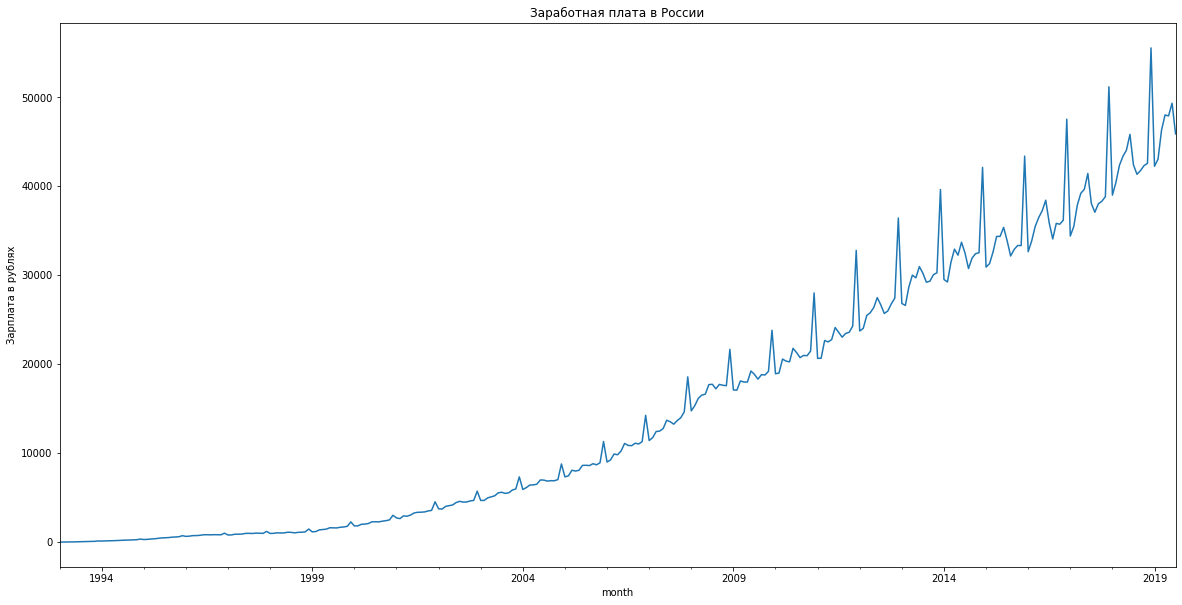

In [6]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.title('Заработная плата в России')
plt.xlabel('Год')
plt.ylabel('Зарплата в рублях')
plt.grid()
salary.salary.plot()
pylab.show()

Критерий Дики-Фуллера: p=0.998558


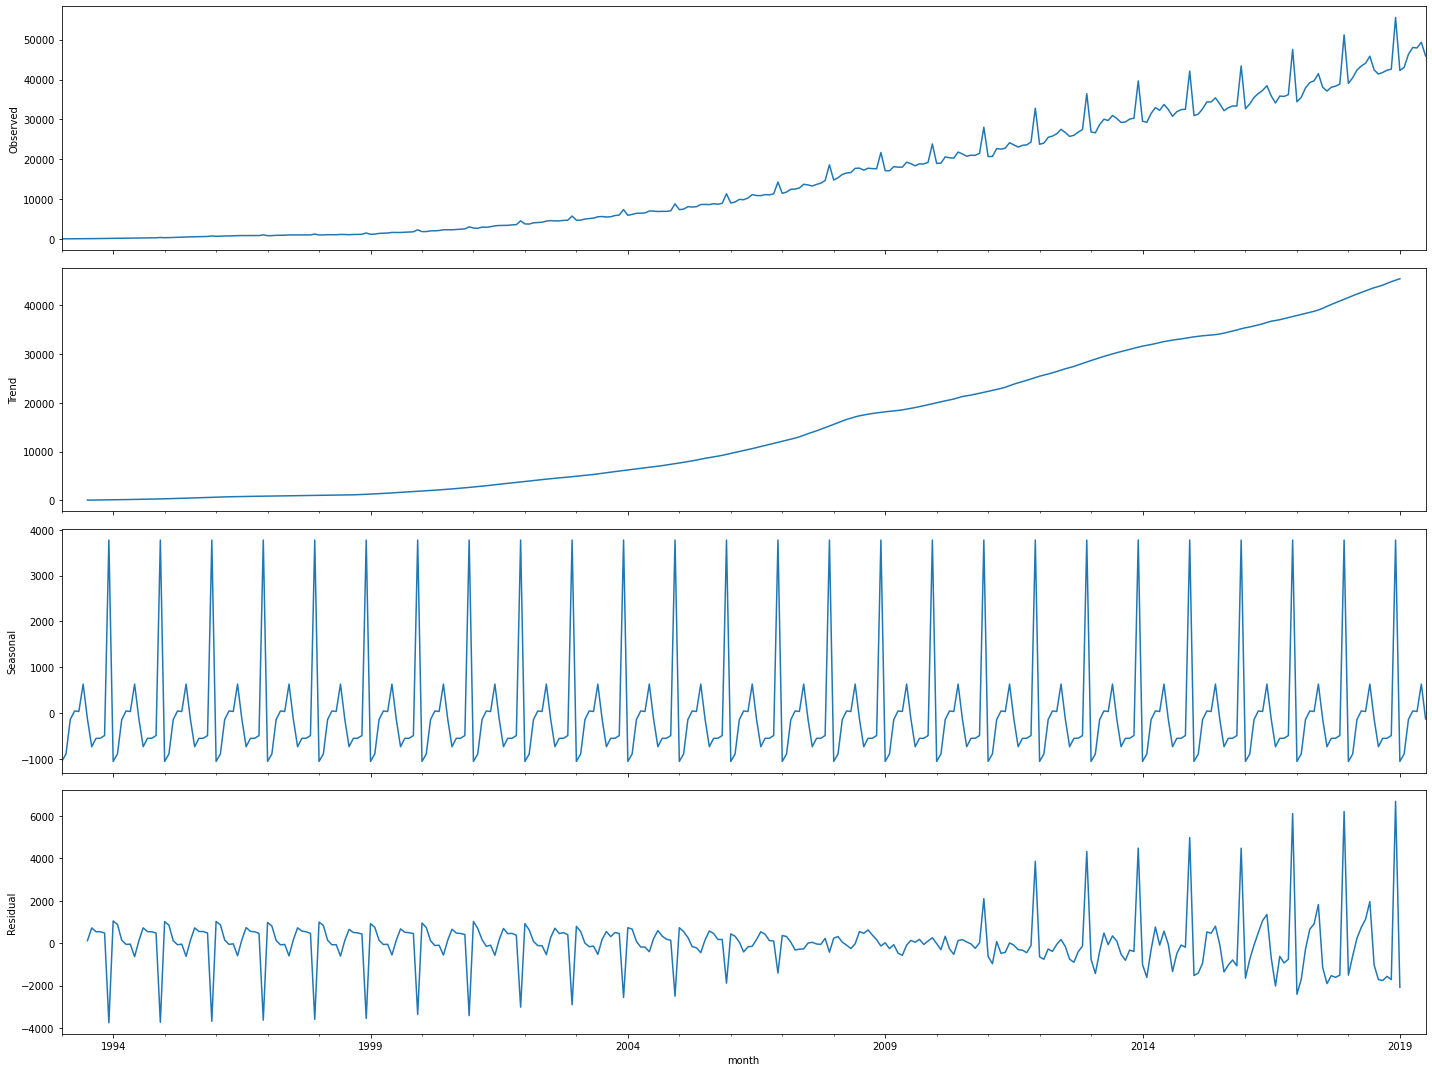

In [8]:
plt.rcParams['figure.figsize'] = (20, 15)
sm.tsa.seasonal_decompose(salary.salary).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary)[1])

### 2. Стабилизация дисперсии методом Бокса-Кокса

Оптимальный параметр преобразования Бокса-Кокса: 0.286118
Критерий Дики-Фуллера: p=0.694071


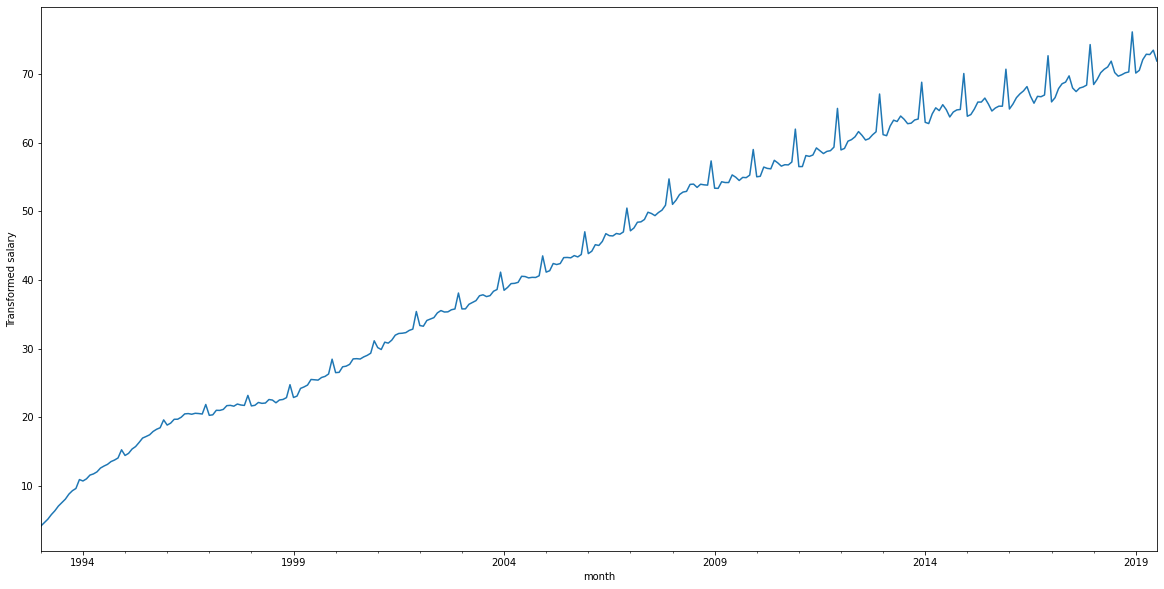

In [10]:
salary['salary_box'], lmbda = stats.boxcox(salary.salary)
plt.rcParams['figure.figsize'] = (20, 10)
salary.salary_box.plot()
plt.ylabel(u'Transformed salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box)[1])

### 3. Выбор порядка дифференцирования

**Проведем сезонное дифференцирование, гипотеза о стационарности отвергается на уровне значимости 0.05, но по графикам видно, что от тренда мы не избавились**

Критерий Дики-Фуллера: p=0.128998


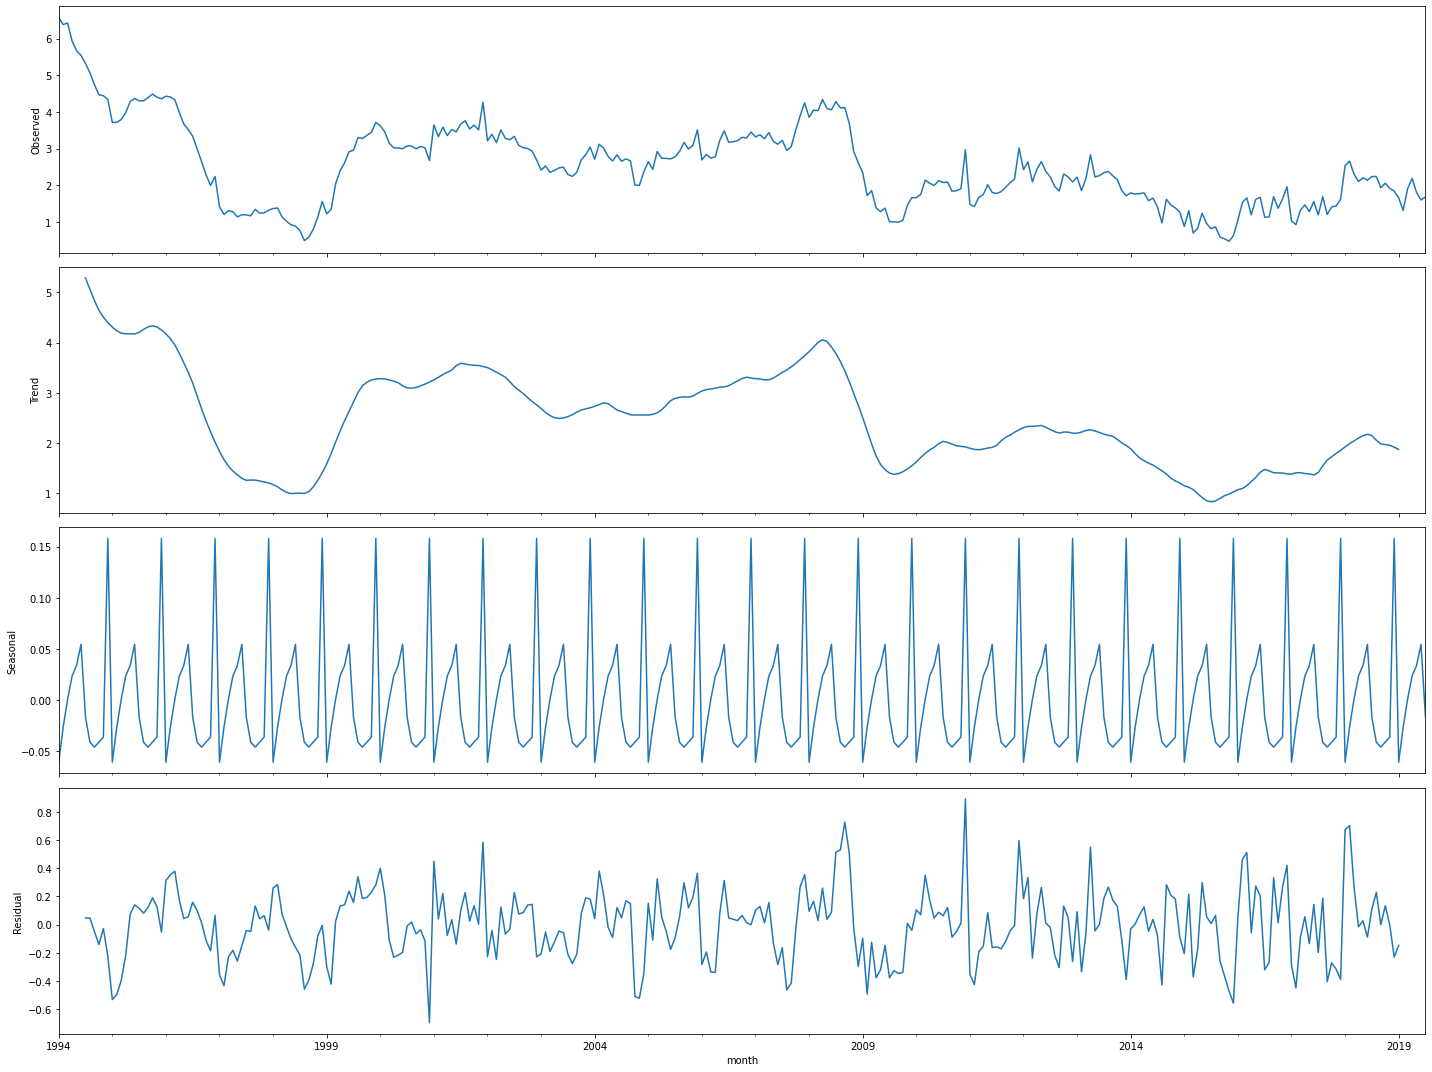

In [12]:
salary['salary_box_diff'] = salary.salary_box - salary.salary_box.shift(12)
plt.rcParams['figure.figsize'] = (20, 15)
sm.tsa.seasonal_decompose(salary.salary_box_diff.dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff.dropna())[1])

**Так как от тренда мы не избавились, проведем дифференцирование еще раз. Теперь уже все, тренда нет, наблюдения и остатки стационарны, критерий Дики-Фулера показывает уверенный 0, графики это подтверждают**

Критерий Дики-Фуллера: p=0.000000


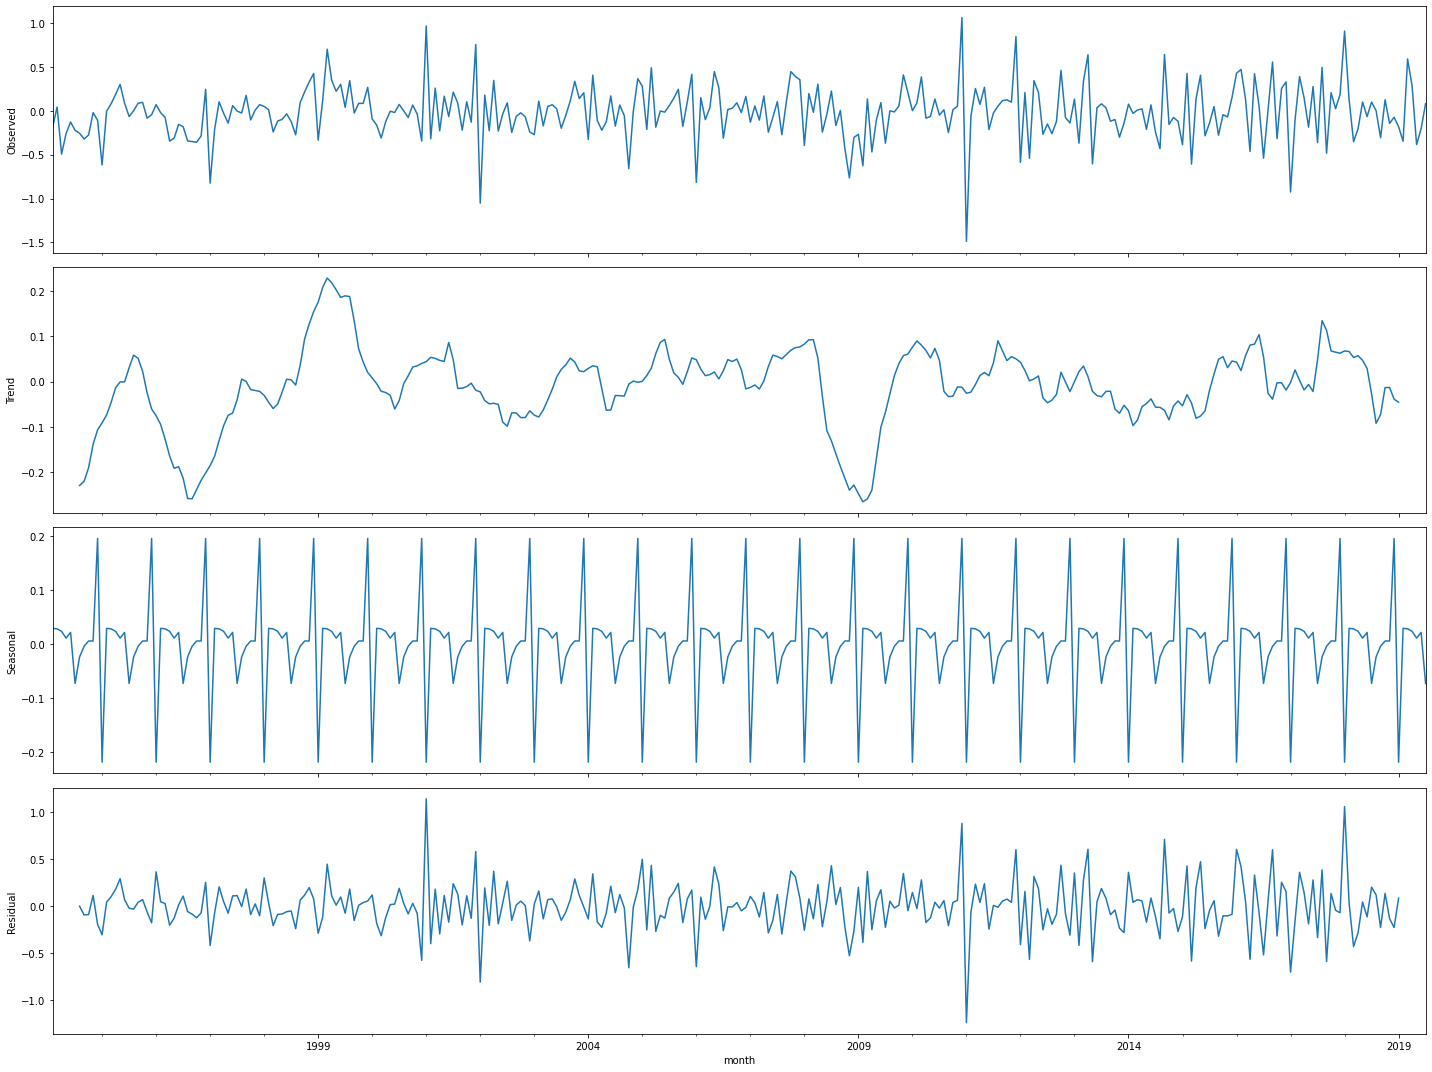

In [14]:
salary['salary_box_diff2'] = salary.salary_box_diff - salary.salary_box_diff.shift(1)
plt.rcParams['figure.figsize'] = (20, 15)
sm.tsa.seasonal_decompose(salary.salary_box_diff2.dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff2.dropna())[1])

### 4. Выбор начальных приближений для p, q, P, Q

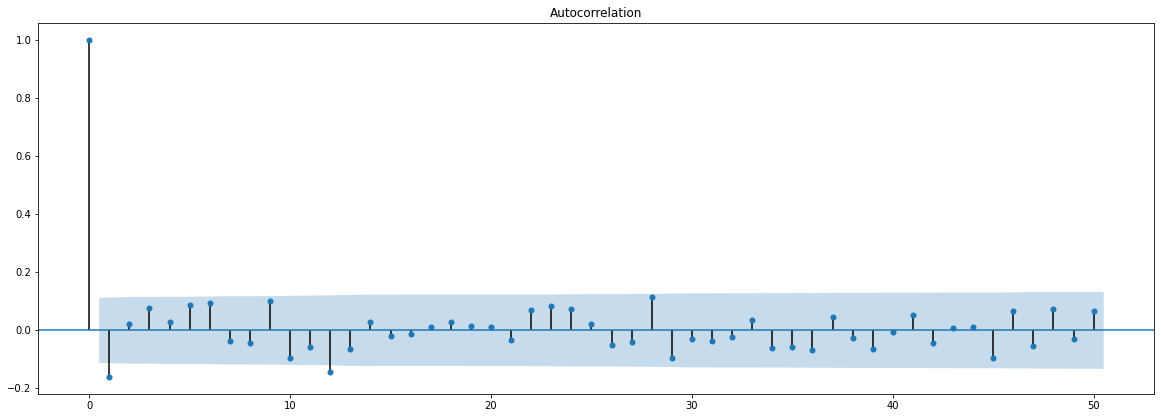

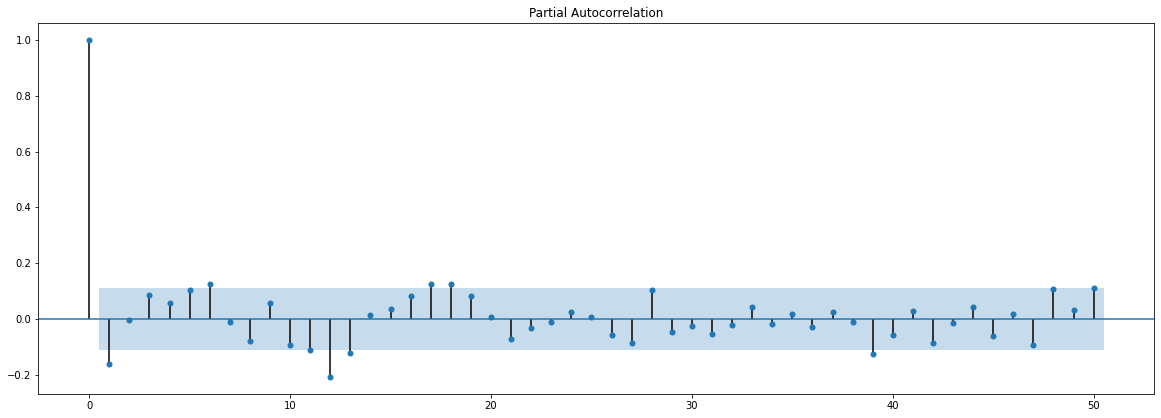

In [16]:
plt.rcParams['figure.figsize'] = (20, 15)
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.salary_box_diff2.dropna(), lags=50, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.salary_box_diff2.dropna(), lags=50, ax=ax)
pylab.show()

**Начальные приближения: Q=0, q=1, P=1, p=1, но для того, чтобы охватить большее множество параметров, используем бОльшие интервалы для приближений**

In [18]:
ps = range(0, 3)
d=1
qs = range(0, 3)
Ps = range(0, 3)
D=1
Qs = range(0, 3)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

81

### 5. Обучение и сравнение моделей

In [20]:
%%time
results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except LinAlgError:
        print('Wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

  0%|          | 0/81 [00:00<?, ?it/s]C:\Users\asus\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
 10%|▉         | 8/81 [00:06<01:20,  1.10s/it]C:\Users\asus\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 78%|███████▊  | 63/81 [02:20<01:27,  4.87s/it]C:\Users\asus\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\asus\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA pa

Wall time: 3min 55s


In [22]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
75  (2, 2, 1, 0)  115.759962
74  (2, 2, 0, 2)  117.093648
78  (2, 2, 2, 0)  119.051194
53  (1, 2, 2, 2)  119.543098
76  (2, 2, 1, 1)  120.892945


In [24]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         salary_box   No. Observations:                  319
Model:             SARIMAX(2, 1, 2)x(1, 1, 0, 12)   Log Likelihood                 -51.880
Date:                            Mon, 13 Apr 2020   AIC                            115.760
Time:                                    13:49:01   BIC                            138.101
Sample:                                01-01-1993   HQIC                           124.695
                                     - 07-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3334      0.084     15.924      0.000       1.169       1.497
ar.L2         -0.5390      0.084   

### 6. Анализ остатков построенной модели

**Остатки несмещены (подтверждается критерием Стьюдента на уровне значимости 0.1, но подтверждается полностью по графику) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).**

Критерий Стьюдента: p=0.576933
Критерий Дики-Фуллера: p=0.000000


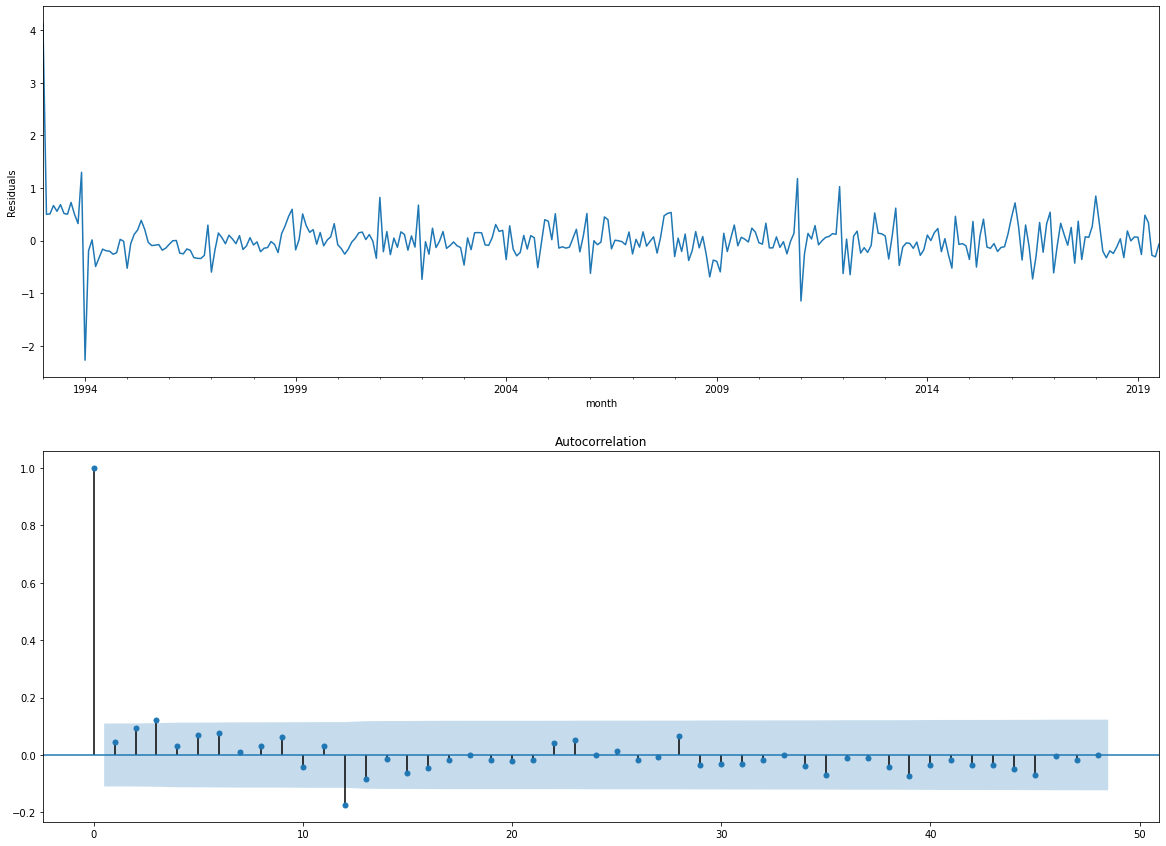

In [26]:
plt.rcParams['figure.figsize'] = (20, 15)
plt.subplot(211)
best_model.resid.dropna().plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.dropna(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid.dropna(), 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid.dropna())[1])

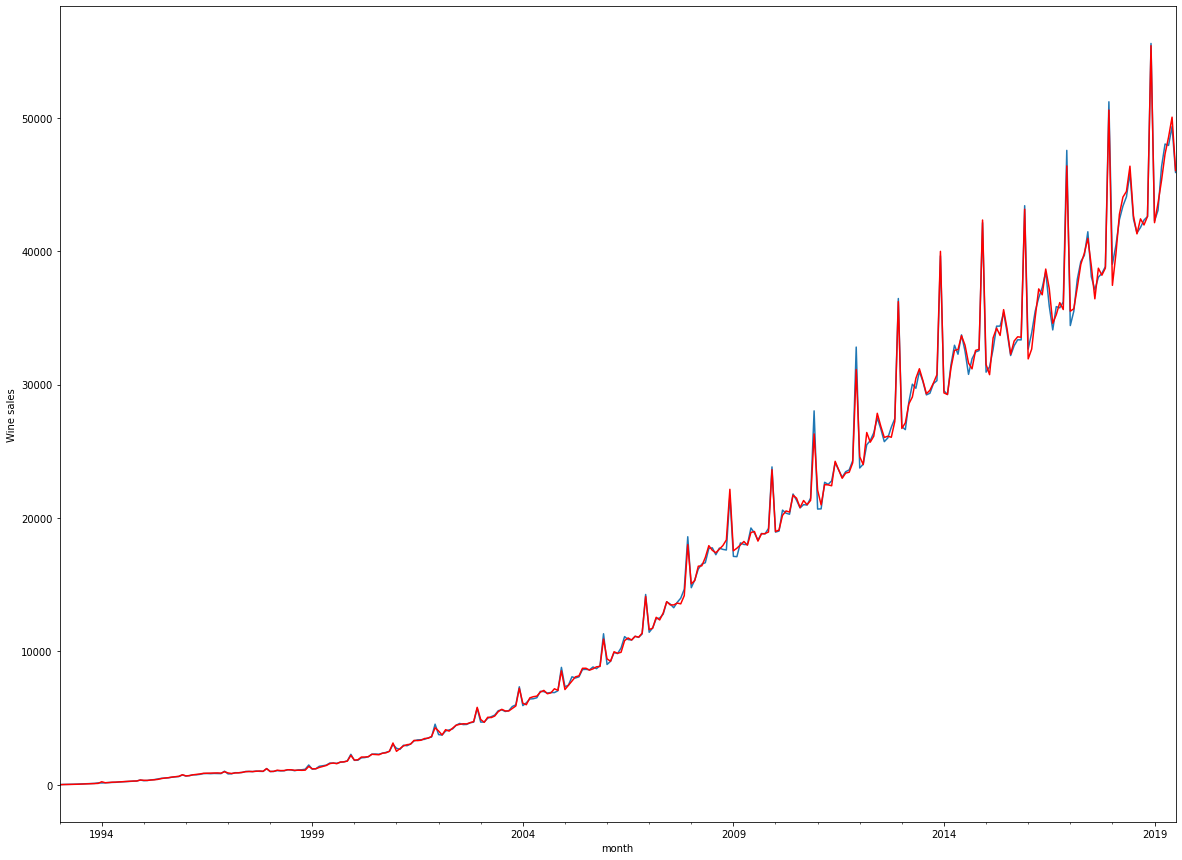

In [28]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.rcParams['figure.figsize'] = (20, 15)
salary.salary.plot()
salary.model.dropna().plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

### 7. Прогнозирование с помощью финальной модели.

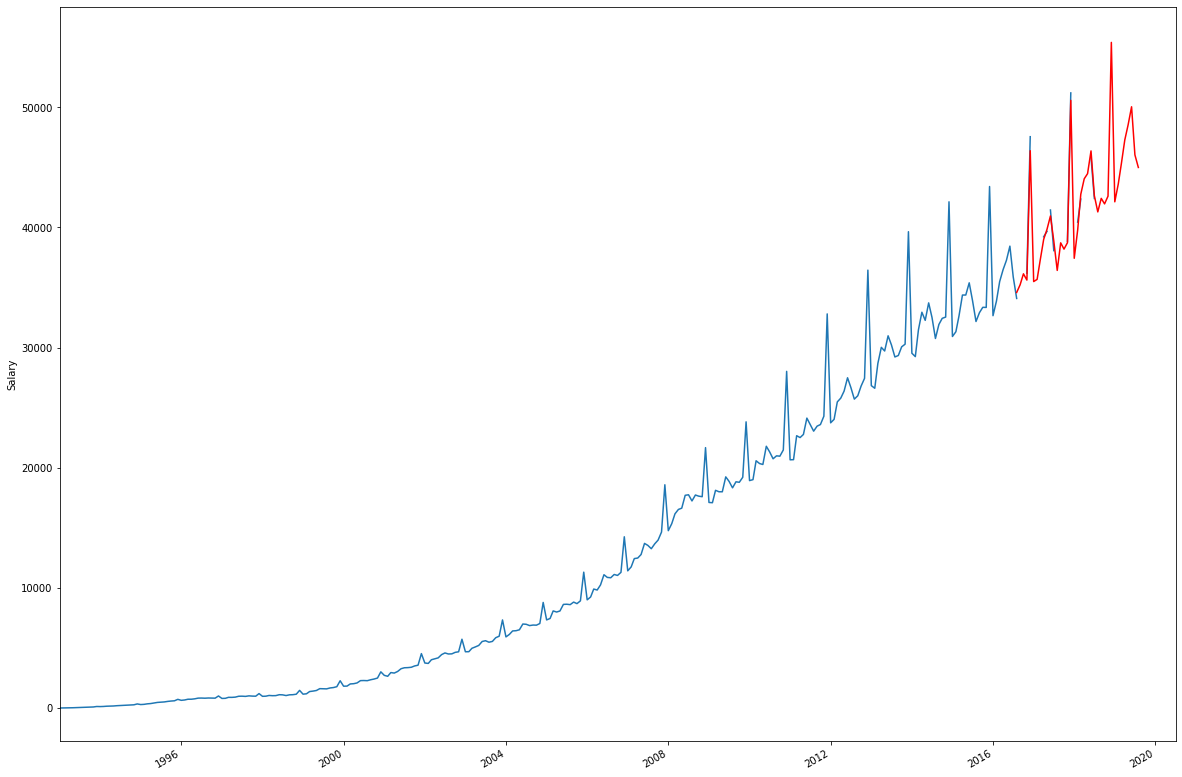

In [30]:
salary2 = salary[['salary']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,48)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=283, end=283+36), lmbda)

plt.rcParams['figure.figsize'] = (20, 15)
salary2.salary.plot()
salary2.forecast.plot(color='r')
plt.ylabel('Salary')
pylab.show()